In [36]:
import pandas as pd
import matplotlib
import xlrd
from matplotlib import pyplot as plt
%matplotlib inline


In [31]:
A = pd.read_csv("~/Documents/Insight/massdriver/data/CrashDataExport_20160603_1053.csv", sep='^', low_memory=False)

In [32]:
A.columns

Index(['Crash Number', 'Crash Date', 'Crash Time', 'Crash Hour', 'City/Town',
       'Crash Severity', 'X', 'Y', 'Is Geocoded', 'Locality',
       'RPA Abbreviation', 'MassHighway District',
       'Maximum Injury Severity Reported', 'Number of NonFatal Injuries',
       'Number of Fatal Injuries', 'Number of Vehicles', 'Manner of Collision',
       'Vehicle Action Prior to Crash', 'Vehicle Travel Directions',
       'First Harmful Event', 'First Harmful Event Location',
       'Most Harmful Events', 'Vehicle Sequence of Events',
       'Vehicle Configuration', 'FMSCA Reportable',
       'Age of Driver - Youngest Known', 'Age of Driver - Oldest Known',
       'Driver Contributing Codes', 'Non Motorist Type', 'Non Motorist Action',
       'Non Motorist Location', 'Hit & Run', 'Road Surface', 'Ambient Light',
       'Weather Condition', 'Street Number', 'Roadway',
       'Distance And Direction From Intersection', 'Near Intersection Roadway',
       'Exit Route', 'Distance And Direction 

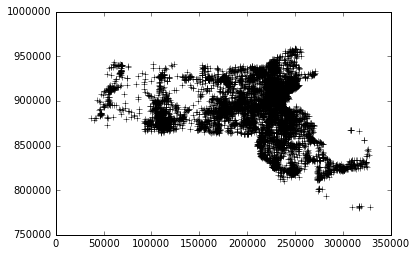

In [39]:
plt.plot(A["X"], A["Y"], 'k+')

In [14]:
help(xlrd)

Help on package xlrd:

NAME
    xlrd

PACKAGE CONTENTS
    biffh
    book
    compdoc
    formatting
    formula
    info
    licences
    sheet
    timemachine
    xldate
    xlsx

FUNCTIONS
    count_records(filename, outfile=<ipykernel.iostream.OutStream object at 0x7f999d0c86a0>)
    
    dump(filename, outfile=<ipykernel.iostream.OutStream object at 0x7f999d0c86a0>, unnumbered=False)
    
    open_workbook(filename=None, logfile=<ipykernel.iostream.OutStream object at 0x7f999d0c86a0>, verbosity=0, use_mmap=1, file_contents=None, encoding_override=None, formatting_info=False, on_demand=False, ragged_rows=False)

DATA
    FMLA_TYPE_ARRAY = 4
    FMLA_TYPE_CELL = 1
    FMLA_TYPE_COND_FMT = 8
    FMLA_TYPE_DATA_VAL = 16
    FMLA_TYPE_NAME = 32
    FMLA_TYPE_SHARED = 2
    MMAP_AVAILABLE = 1
    USE_MMAP = 1
    XL_CELL_BLANK = 6
    XL_CELL_BOOLEAN = 4
    XL_CELL_DATE = 3
    XL_CELL_EMPTY = 0
    XL_CELL_ERROR = 5
    XL_CELL_NUMBER = 2
    XL_CELL_TEXT = 1
    __VERSION__ = '0.9.4'

In [22]:
A["Crash Date"] = pd.to_datetime(A["Crash Date"])

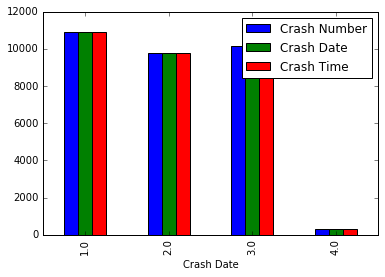

In [23]:
A.groupby(A["Crash Date"].dt.month).count().plot(kind="bar")